## Skin Cancer Classification Transfer Learning InceptionResNetV2

In [1]:
import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import sklearn

### Creating Dataset

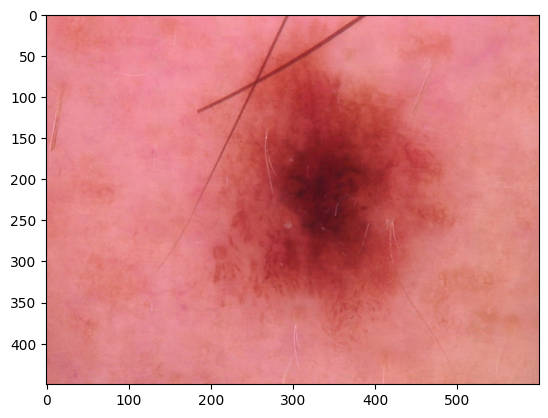

(450, 600, 3)


In [2]:
img = os.listdir('HAM_images')[0]
skin=cv2.imread('HAM_images/'+img)
plt.imshow(cv2.cvtColor(skin, cv2.COLOR_BGR2RGB))
plt.show()

print(skin.shape)

In [3]:
mapping = {
    "MEL": 1,
    "NV": 2,
    "BCC": 3,
    "AKIEC": 4,
    "BKL": 5,
    "DF": 6,
    "VASC": 7
}

df_labels = pd.read_csv("HAM10000_metadata.csv")
newData = pd.DataFrame(columns=["image","MEL","NV","BCC","AKIEC","BKL","DF","VASC","label"])
for i in range(len(df_labels)):
    tempy = [0,0,0,0,0,0,0,0,0]
    tempy[0] = df_labels.iloc[i]["image_id"]
    tempy[-1] = df_labels.iloc[i]["dx"].upper()
    tempy[mapping[df_labels.iloc[i]["dx"].upper()]] = 1.0
    newData.loc[len(newData)] = tempy

df_labels.head(),newData

(     lesion_id      image_id   dx dx_type   age   sex localization
 0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp
 1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp
 2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp
 3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp
 4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear,
               image  MEL   NV  BCC  AKIEC  BKL   DF  VASC  label
 0      ISIC_0027419  0.0  0.0  0.0    0.0  1.0  0.0   0.0    BKL
 1      ISIC_0025030  0.0  0.0  0.0    0.0  1.0  0.0   0.0    BKL
 2      ISIC_0026769  0.0  0.0  0.0    0.0  1.0  0.0   0.0    BKL
 3      ISIC_0025661  0.0  0.0  0.0    0.0  1.0  0.0   0.0    BKL
 4      ISIC_0031633  0.0  0.0  0.0    0.0  1.0  0.0   0.0    BKL
 ...             ...  ...  ...  ...    ...  ...  ...   ...    ...
 10010  ISIC_0033084  0.0  0.0  0.0    1.0  0.0  0.0   0.0  AKIEC
 10011  ISIC_0033550  0.0  0.0  0.0    1.0  0.0  0.0   0.0  AKI

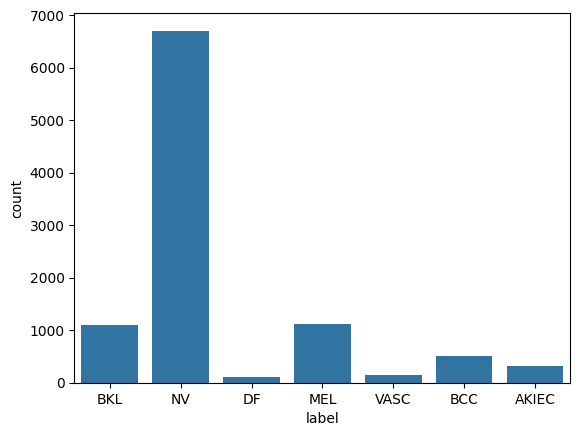

In [4]:
sns.countplot(x="label",data=newData)
plt.show()

### Train Test Split

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet_v2 import preprocess_input as base_preprocess


image_gen = ImageDataGenerator(
                               preprocessing_function=base_preprocess,
                               rotation_range=30,
                               width_shift_range=0.1,
                               height_shift_range=0.1,
                               shear_range=0.1,
                               zoom_range=0.2,
                               horizontal_flip=True,
                               fill_mode='nearest',
                               # rescale=1/255,
                               validation_split=0.15)

data_dir = 'HAM_Dataset'
batch_size = 64
target_size = (224,224)
train_image_gen = image_gen.flow_from_directory(data_dir, 
                                          target_size=target_size,
                                          color_mode='rgb',
                                          batch_size=batch_size,
                                          class_mode='categorical',
                                          subset="training")

test_image_gen = image_gen.flow_from_directory(data_dir, 
                                          target_size=target_size, 
                                          color_mode='rgb',
                                          batch_size=batch_size,
                                          class_mode='categorical',
                                          shuffle=False,
                                          subset="validation")

print(test_image_gen.class_indices)

2024-10-16 13:40:13.735701: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-16 13:40:13.973086: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-16 13:40:14.033197: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-16 13:40:14.498496: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-16 13:40:16.558792: W tensorflow/compiler/tf2

Found 8516 images belonging to 7 classes.
Found 1499 images belonging to 7 classes.
{'AKIEC': 0, 'BCC': 1, 'BKL': 2, 'DF': 3, 'MEL': 4, 'NV': 5, 'VASC': 6}


<Axes: ylabel='count'>

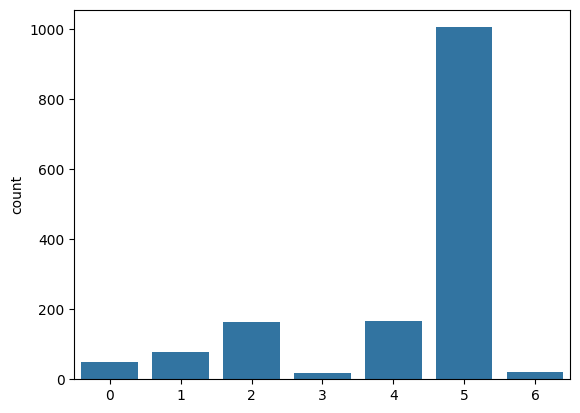

In [6]:
sns.countplot(x=test_image_gen.classes)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.6340952..0.98401904].


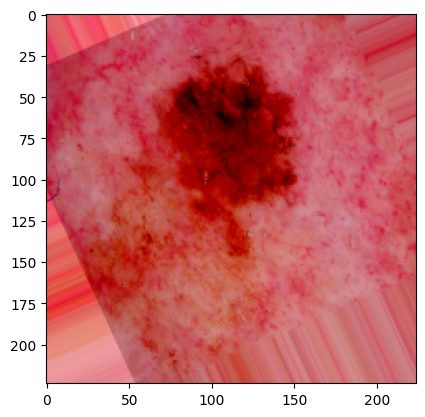

In [7]:
plt.imshow(train_image_gen[0][0][0])

## Transfer Learning using InceptionResNetV2 Model

In [8]:
from tensorflow.keras.applications import *
from tensorflow.keras.layers import Flatten, Dense, Input, Dropout,GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

base_model = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers:
    layer.trainable = True

x = base_model.output
x = GlobalAveragePooling2D()(x)
# x = Flatten()(x)
# x = Dense(4096, activation='relu')(x)
# x = Dropout(0.5)(x)
# x = Dense(512, activation='relu')(x)
# x = Dropout(0.5)(x)
x = Dense(128,kernel_regularizer='l2',activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(7, activation='softmax')(x)
tl_model = Model(inputs=base_model.input, outputs=x)


tl_model.summary()

I0000 00:00:1729086020.866699     489 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729086021.391469     489 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729086021.391532     489 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729086021.394988     489 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729086021.395076     489 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:0

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 111, 111,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 111, 111,  │         96 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 111, 111,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 109, 109,  │      9,216 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 109, 109,  │         96 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 109, 109,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 109, 109,  │     18,432 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 109, 109,  │        192 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 109, 109,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 54, 54,    │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 54, 54,    │      5,120 │ max_pooling2d[0]… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 54, 54,    │        240 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 54, 54,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 52, 52,    │    138,240 │ activation_3[0][… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 52, 52,    │        576 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 52, 52,    │          0 │ batch_normalizat

 Total params: 54,534,375 (208.03 MB)

 Trainable params: 54,473,831 (207.80 MB)

 Non-trainable params: 60,544 (236.50 KB)

In [9]:
optimizer = Adam(0.0001)
tl_model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

### Model Training

In [10]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

lr_reduce = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=2,mode='max', min_lr=0.00001,verbose=1)
early_stop = EarlyStopping(monitor="val_loss", patience=2, verbose=1)
model_chkpt = ModelCheckpoint('inception.keras',save_best_only=True, monitor='val_accuracy',verbose=1)

callback_list = [model_chkpt,lr_reduce]

In [11]:
history = tl_model.fit(train_image_gen,
                       epochs=15, 
                       validation_data = test_image_gen,
                       callbacks=callback_list)

/home/blaise/anaconda3/envs/py310/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15


I0000 00:00:1729086088.710822     577 service.cc:146] XLA service 0x7f84b0003d20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1729086088.710877     577 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2024-10-16 13:41:30.955976: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-10-16 13:41:39.630216: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
2024-10-16 13:41:49.491360: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_53080', 336 bytes spill stores, 336 bytes spill loads

2024-10-16 13:41:49.930500: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in fun

108/134 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.5828 - loss: 3.4701

2024-10-16 13:46:24.487335: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion', 164 bytes spill stores, 164 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_1', 132 bytes spill stores, 132 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_126', 48 bytes spill stores, 48 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_127', 32 bytes spill stores, 32 bytes spill loads



134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6042 - loss: 3.3918

2024-10-16 13:47:39.179734: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_5400', 28 bytes spill stores, 28 bytes spill loads

2024-10-16 13:47:39.193086: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_5400', 172 bytes spill stores, 172 bytes spill loads




Epoch 1: val_accuracy improved from -inf to 0.70314, saving model to inception.keras
134/134 ━━━━━━━━━━━━━━━━━━━━ 443s 2s/step - accuracy: 0.6049 - loss: 3.3890 - val_accuracy: 0.7031 - val_loss: 2.9264 - learning_rate: 1.0000e-04
Epoch 2/15
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8081 - loss: 2.3976
Epoch 2: val_accuracy improved from 0.70314 to 0.78252, saving model to inception.keras
134/134 ━━━━━━━━━━━━━━━━━━━━ 172s 1s/step - accuracy: 0.8082 - loss: 2.3969 - val_accuracy: 0.7825 - val_loss: 2.2699 - learning_rate: 1.0000e-04
Epoch 3/15
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8421 - loss: 1.9497
Epoch 3: val_accuracy improved from 0.78252 to 0.82055, saving model to inception.keras
134/134 ━━━━━━━━━━━━━━━━━━━━ 172s 1s/step - accuracy: 0.8421 - loss: 1.9490 - val_accuracy: 0.8205 - val_loss: 1.8022 - learning_rate: 1.0000e-04
Epoch 4/15
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8908 - loss: 1.5510
Epoch 4: val_accuracy improved from 0.82055 t

### Model Evaluation

In [12]:
df=pd.DataFrame(tl_model.history.history)
df.to_csv('hist3.csv')

<Axes: >

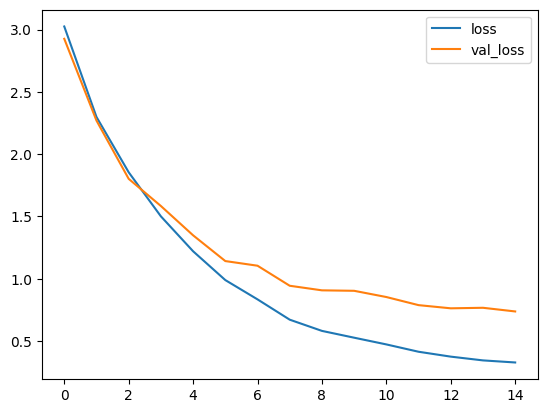

In [13]:
metrics = pd.DataFrame(tl_model.history.history)
metrics[["loss","val_loss"]].plot()

<Axes: >

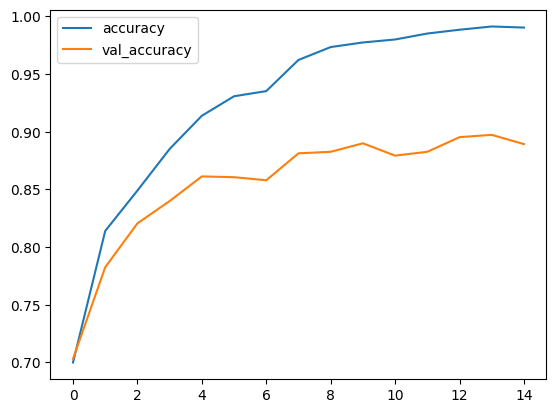

In [14]:
metrics[["accuracy","val_accuracy"]].plot()

In [15]:
predictions = tl_model.predict(test_image_gen, verbose=1)
predictions = predictions.argmax(axis=1)

test_labels = test_image_gen.classes

24/24 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step


In [16]:
pred_df = pd.DataFrame({"true":test_labels, "pred":predictions})
pred_df.to_csv("pred_df.csv")

In [17]:
print(classification_report(test_labels, predictions))

NameError: name 'classification_report' is not defined

In [ ]:
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.figure(figsize=(7,7))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

    
cm_plot_labels = list(test_image_gen.class_indices.keys())

plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix', normalize=True)